## Script Engine Performance Test

Three JS engines were compared using common Hotspot and [GraalVM](https://www.graalvm.org/) CE and EE: Graal JS (for Graal VM only), Rhino and Nashorn. These tests were used: [google-v8](https://github.com/v8/v8/tree/master/benchmarks) 

Benchmark suites were runned repeatedly for code warmup (JIT compiller optimization). 

**System Configuration**:

OS: Ubuntu 18.04<br>

Processor: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz x 4<br>

RAM: 8 GB

Java: <br>

 - Hotspot VM:<br><br>
`java version "1.8.0_171"
Java(TM) SE Runtime Environment (build 1.8.0_171-b11)
Java HotSpot(TM) 64-Bit Server VM (build 25.171-b11, mixed mode)`
<br><br>

 - GraalVM CE:<br><br>
`openjdk version "1.8.0_212"
OpenJDK Runtime Environment (build 1.8.0_212-20190420092731.buildslave.jdk8u-src-tar--b03)
OpenJDK GraalVM CE 19.0.0 (build 25.212-b03-jvmci-19-b01, mixed mode)`
<br><br>

 - GraalVM EE:<br><br>
`openjdk version "1.8.0_212"
Java(TM) SE Runtime Environment (build 1.8.0_212-b31)
Java HotSpot(TM) GraalVM EE 19.0.0 (build 25.212-b31-jvmci-19-b01, mixed mode)`

In [1]:
# notebook import
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import json
import scipy.stats.mstats as mstats
from cycler import cycler

In [2]:
# matplotlib color cycle customization
color_cycle = [
    'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 
    'black', 'purple', 'pink', 'brown', 'orange', 'teal', 
    'coral', 'lightblue', 'lime', 'lavender', 'turquoise', 
    'darkgreen', 'tan', 'salmon', 'gold'
]
plt.rc('axes', prop_cycle=(cycler('color', color_cycle)))

In [3]:
# main parameters for data analysis

# folder with all the dataset files
results_folder = "../../data"
# count of runs used in analysis of performance dynamic
run_count = 500
# count of last analysed runs for mean scoring analysis
measure_count = 100

Define each case name: 
 * "rhino-0" - Rhino with "optimization-level=0" 
 * "rhino-9" - Rhino with "optimization-level=9"
 * "nashorn" - Nashorn with default settings
 * "nashorn-opt" -  Nashorn with "optimistic-types=true"
 * "graal-js" -  Graal JS

In [4]:
vm_cases = ["common-hotspot", "graalvm-ce", "graalvm-ee"]
engine_cases = {
    "common-hotspot": ["rhino-0", "rhino-9", "nashorn", "nashorn-opt"],
    "graalvm-ce": ["rhino-0", "rhino-9", "nashorn", "nashorn-opt", "graal-js"],
    "graalvm-ee": ["rhino-0", "rhino-9", "nashorn", "nashorn-opt", "graal-js"]
}

In [5]:
def load_engine_data(engine, vm_case):
    with open(results_folder + "/" + vm_case + "/" + engine + ".json", 'r') as file:
        return json.load(file)

In [6]:
# load data from JSON-files
data = {
    vm_case: {
        case: load_engine_data(case, vm_case) 
        for case in engine_cases[vm_case]
    } for vm_case in vm_cases
}

In [7]:
def prepare_suits_score_data_set(data, vm_case):
    suit_names = [key for key in data["nashorn"][0]["suits"]]
    return {
        suit_name: {
            engine_case: [
                float(data[engine_case][i]["suits"][suit_name]["score"])
                for i in range(run_count)
            ]
            for engine_case in engine_cases[vm_case]
        }
        for suit_name in suit_names
    }


def prepare_total_score_data_set(data, vm_case):
    return {
        engine_case: [
            float(data[engine_case][i]["totalScore"]) 
            for i in range(run_count)
        ]
        for engine_case in engine_cases[vm_case]
    }

In [8]:
def prepare_data_sets(data, vm_case):  
    return prepare_suits_score_data_set(data, vm_case), \
           prepare_total_score_data_set(data, vm_case)

In [9]:
# datasets preparing:
# - suits_score_data_set: dataset with score measurement 
#                         for each benchmark suit (cases group)
# - total_score_data_set: dataset with score measurement 
#                         for each engine case 
#                        (see description for "engine_cases" variable)
score_data_sets_tuple = {
    vm_case: prepare_data_sets(data[vm_case], vm_case) 
    for vm_case in vm_cases
}

suits_score_data_set = {
    vm_case: score_data_sets_tuple[vm_case][0]
    for vm_case in vm_cases
}
total_score_data_set = {
    vm_case: score_data_sets_tuple[vm_case][1]
    for vm_case in vm_cases
}

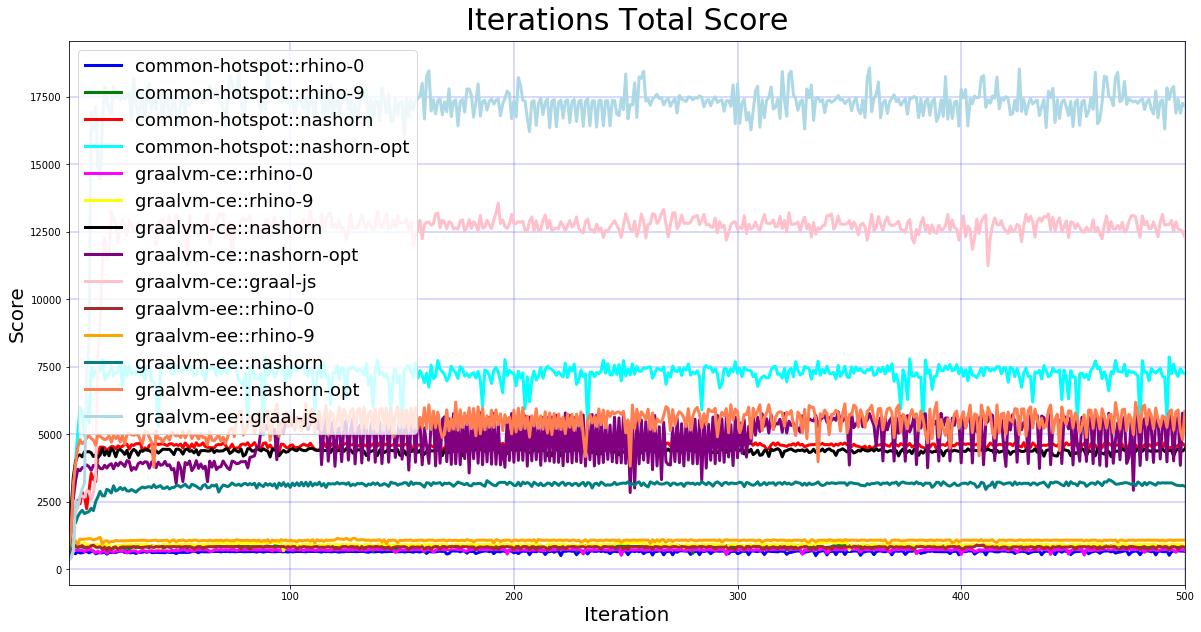

In [10]:
# plot for "total_score_data_set" dynamic

plt.figure(figsize=(20, 10))
x = np.arange(1, run_count + 1)

for vm_case in total_score_data_set:
    for engine_case in total_score_data_set[vm_case].keys():
        plt.plot(
            x, total_score_data_set[vm_case][engine_case], 
            linewidth=3, label=vm_case + "::" + engine_case
        )
    
plt.ylabel("Score", size=20)
plt.xlabel("Iteration", size=20)
plt.grid(color='b', linestyle='-', linewidth=0.3)
plt.legend(prop={'size': 18})
plt.title('Iterations Total Score', fontsize=30, y=1.01)
plt.xlim(xmin=1, xmax=run_count)
plt.show()

In [11]:
def prepare_suits_score_relative_set(suits_score_data_set, vm_case):
    suits_score_means = {
        suit_name: {
            engine_case:
                mstats.gmean(
                    suits_score_data_set[suit_name] \
                        [engine_case][-measure_count:],
                    dtype=float
                )
            for engine_case in engine_cases[vm_case]
        }
        for suit_name in suits_score_data_set
    }

    result = {}
    
    for suit_name in suits_score_means:
        min_suits_score = min(suits_score_means[suit_name].values())
        result[suit_name] = {
            engine_case: 
                suits_score_means[suit_name][engine_case] / min_suits_score
            for engine_case in engine_cases[vm_case]
        }

    return result


def prepare_total_score_relative_set(total_score_data_set, vm_case):
    total_score_means = {
        engine_case: mstats.gmean(
            total_score_data_set[engine_case][-measure_count:],
            dtype=float
        )
        for engine_case in engine_cases[vm_case]
    }

    min_total_score = min(total_score_means.values())

    return {
        engine_case: total_score_means[engine_case] / min_total_score
        for engine_case in engine_cases[vm_case]
    }


In [12]:
# - suits_score_relative_set: geometric mean
#                    for last <measure_count> analyzed runs' score 
#                    for each benchmark suit and each engine case
suits_score_relative_set = {
    vm_case:
        prepare_suits_score_relative_set(
            suits_score_data_set[vm_case], 
            vm_case
        ) for vm_case in vm_cases    
}
# - total_score_relative_set: geometric mean
#                    for last <measure_count> analyzed runs' total score 
#                    for each engine case
total_score_relative_set = {
    vm_case:
        prepare_total_score_relative_set(
            total_score_data_set[vm_case], 
            vm_case
        ) for vm_case in vm_cases    
}

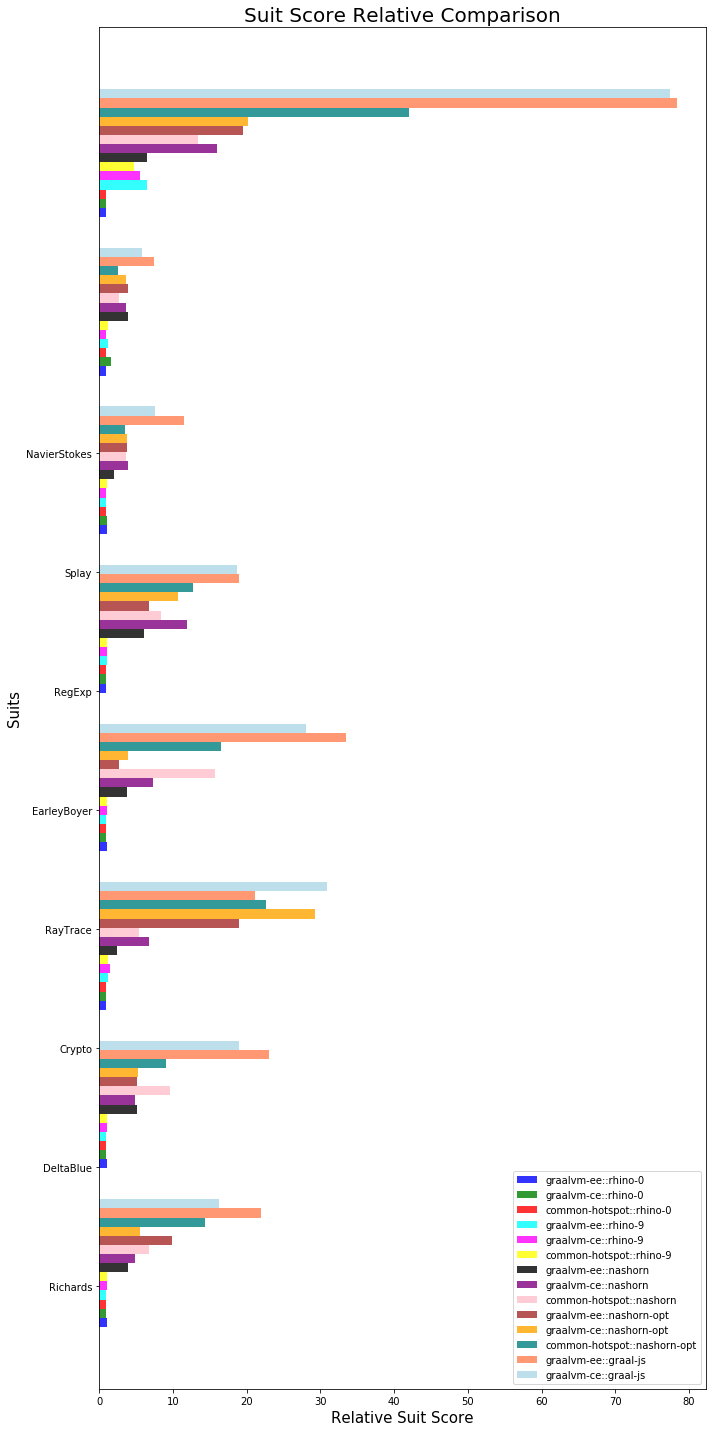

In [13]:
# horizontal bars for relative engine cases' score comparision 
# for each benchmark suit

n_groups = len(suits_score_relative_set["common-hotspot"].keys())

fig, ax = plt.subplots(figsize=(10, 20))
index = np.arange(n_groups)
bar_width = 0.23
opacity = 0.8
 
for i, engine_case in enumerate(total_score_relative_set["graalvm-ce"]):
    plt.barh(
        4 * index + 3 * i * bar_width, 
        [
            suits_score_relative_set["graalvm-ee"][suits][engine_case] 
            for suits in suits_score_relative_set["graalvm-ee"]
        ], 
        bar_width,
        alpha=opacity, label="graalvm-ee::" + engine_case
    )
    plt.barh(
        4 * index + (3 * i + 1) * bar_width, 
        [
            suits_score_relative_set["graalvm-ce"][suits][engine_case] 
            for suits in suits_score_relative_set["graalvm-ce"]
        ], 
        bar_width,
        alpha=opacity, label="graalvm-ce::" + engine_case
    )
    if engine_case != "graal-js":
        plt.barh(
            4 * index + (3 * i + 2) * bar_width, 
            [
                suits_score_relative_set["common-hotspot"][suits][engine_case] 
                for suits in suits_score_relative_set["common-hotspot"]
            ], 
            bar_width,
            alpha=opacity, label="common-hotspot::" + engine_case
        )
 
plt.ylabel('Suits', size=15)
plt.xlabel('Relative Suit Score', size=15)
plt.title('Suit Score Relative Comparison', size=20)
plt.yticks(3 * index + 4 * bar_width, suits_score_relative_set["common-hotspot"].keys())
plt.legend()
 
plt.tight_layout()
plt.show()

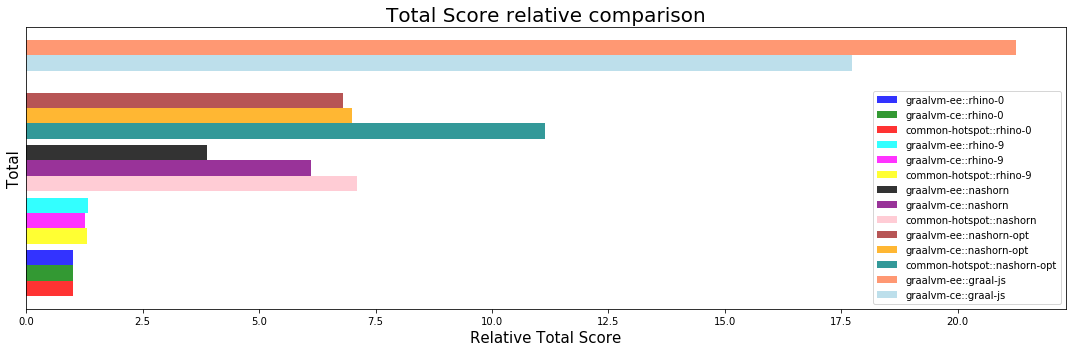

In [14]:
# horizontal bar for relative engine cases' total score comparision

plt.figure(figsize=(15, 5))
bar_width = 0.35
opacity = 0.8

for i, engine_case in enumerate(total_score_relative_set["graalvm-ce"]):
    plt.barh(
        1 + bar_width * (3 * i + 2) + 0.15 * i, 
        total_score_relative_set["graalvm-ee"][engine_case], 
        bar_width, 
        alpha=opacity, label="graalvm-ee::" + engine_case
    )
    plt.barh(
        1 + bar_width * (3 * i + 1) + 0.15 * i, 
        total_score_relative_set["graalvm-ce"][engine_case], 
        bar_width, 
        alpha=opacity, label="graalvm-ce::" + engine_case
    )
    if engine_case != "graal-js":
        plt.barh(
            1 + 3 * bar_width * i + 0.15 * i, 
            total_score_relative_set["common-hotspot"][engine_case], 
            bar_width, 
            alpha=opacity, label="common-hotspot::" + engine_case
        )
 
plt.ylabel('Total', size=15)
plt.xlabel('Relative Total Score', size=15)
plt.title('Total Score relative comparison', size=20)
plt.yticks([0], ["Total Score"])
plt.legend()
 
plt.tight_layout()
plt.show()